<a href="https://colab.research.google.com/github/renaldfredy/Thesis/blob/main/Attempt_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MHA-Bi-GRU-AL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q -U keras-tuner

In [ ]:
pip install attention

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional, GRU
from tensorflow.keras.layers import Dropout, Embedding, TimeDistributed
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Conv1D, MaxPooling2D
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.models import model_from_json
from keras_tuner.tuners import RandomSearch, BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
import warnings
import pickle
warnings.filterwarnings("ignore")

In [ ]:
seed_value= 42

# Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

# Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
np.random.seed(42)

# Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

print(tf.random.uniform([42]).numpy())

[0.6645621  0.44100678 0.3528825  0.46448255 0.03366041 0.68467236
 0.74011743 0.8724445  0.22632635 0.22319686 0.3103881  0.7223358
 0.13318717 0.5480639  0.5746088  0.8996835  0.00946367 0.5212307
 0.6345445  0.1993283  0.72942245 0.54583454 0.10756552 0.6767061
 0.6602763  0.33695042 0.60141766 0.21062577 0.8527372  0.44062173
 0.9485276  0.23752594 0.81179297 0.5263394  0.494308   0.21612847
 0.8457197  0.8718841  0.3083862  0.6868038  0.23764038 0.7817228 ]


In [ ]:
# trying open dataset

pickle_in_tr_0 =open("/content/drive/MyDrive/Renald/Preprosessing_data/Data_Train_0_3D.pickle",'rb')
Xtrain_0 = pickle.load(pickle_in_tr_0)

pickle_in_val_0 =open("/content/drive/MyDrive/Renald/Preprosessing_data/Data_Val_0_3D.pickle",'rb')
Xval_0 = pickle.load(pickle_in_val_0)

pickle_in_ts_0 =open("/content/drive/MyDrive/Renald/Preprosessing_data/Data_Test_0_3D.pickle",'rb')
Xtest_0 = pickle.load(pickle_in_ts_0)

# print(Xtrain_0)
print(Xtrain_0.shape)
print(Xval_0.shape)
print(Xtest_0.shape)

(288, 779, 9)
(96, 779, 9)
(96, 779, 9)


In [ ]:
Xtrain_0_transpose = np.transpose(Xtrain_0, (1, 0, 2))
Xval_0_transpose = np.transpose(Xval_0, (1, 0, 2))
Xtest_0_transpose = np.transpose(Xtest_0, (1, 0, 2))
Xtrain_0_transpose.shape

(779, 288, 9)

In [ ]:
pd.DataFrame(Xtrain_0_transpose[0,:,:])

,0,1,2,3,4,5,6,7,8
0,467.086792,450.509216,450.493469,463.481934,463.987152,463.586304,464.221161,454.073120,455.535645
1,329.553650,332.110718,325.165436,323.138031,323.946747,319.100983,314.429291,315.854004,303.505096
2,191.304688,194.310349,203.168213,202.327225,205.625854,213.830566,176.942657,181.324371,209.248688
3,256.511261,251.699554,267.314087,243.805115,245.511902,236.010803,235.431396,237.056396,260.986267
4,279.643127,282.230225,272.270935,316.828491,316.661316,316.682556,312.520203,317.095947,324.420502
...,...,...,...,...,...,...,...,...,...
283,60.454823,59.164959,56.321915,55.674461,55.289906,55.024635,51.097076,52.276787,51.822144
284,172.461365,176.396820,169.387512,163.660828,167.206573,169.016296,155.282013,156.945465,152.179138
285,496.523712,474.888702,442.202393,452.599274,436.002808,429.640381,437.117737,416.009094,408.426270
286,495.616272,490.365662,472.015747,517.323975,516.460815,506.097412,524.550171,525.824524,511.208405


In [ ]:
data_ = Xtrain_0_transpose[0,:,:]
data_

array([[467.08679199, 450.50921631, 450.49346924, ..., 464.22116089,
        454.07312012, 455.53564453],
       [329.5536499 , 332.11071777, 325.16543579, ..., 314.42929077,
        315.85400391, 303.50509644],
       [191.3046875 , 194.31034851, 203.16821289, ..., 176.94265747,
        181.32437134, 209.24868774],
       ...,
       [496.52371216, 474.88870239, 442.20239258, ..., 437.11773682,
        416.00909424, 408.42626953],
       [495.61627197, 490.36566162, 472.01574707, ..., 524.5501709 ,
        525.82452393, 511.20840454],
       [486.00543213, 460.50759888, 448.29470825, ..., 473.24786377,
        447.20809937, 448.11706543]])

In [ ]:
data_train = []
data_ytrain = []
data_xval = []
data_yval = []
data_xtest = []
data_ytest = []

for j in range (0,779):
  data_x = Xtrain_0_transpose[j,:,:]
  data_train.append(data_x)
  data_y = Xtrain_0_transpose[[j],:,[4]].reshape(288,1)
  data_ytrain.append(data_y)
  data_val_x =  Xval_0_transpose[j,:,:]
  data_xval.append(data_val_x)
  data_val_y = Xval_0_transpose[[j],:,[4]].reshape(96,1)
  data_yval.append(data_val_y)
  data_test_x =  Xtest_0_transpose[j,:,:]
  data_xtest.append(data_test_x)
  data_test_y = Xtest_0_transpose[[j],:,[4]].reshape(96,1)
  data_ytest.append(data_test_y)

print(data_train[0].shape)
print(data_ytrain[0].shape)
print(data_xval[0].shape)
print(data_yval[0].shape)
print(data_xtest[0].shape)
print(data_ytest[0].shape)


(288, 9)
(288, 1)
(96, 9)
(96, 1)
(96, 9)
(96, 1)


In [ ]:
scaler = StandardScaler()
n_input = 1
n_output = 1
n_features = 9
batch_size = 12
data_gent = []
data_val_gent = []
data_test_gent = []

for k in range (0,779):
  data_train_scaled = scaler.fit_transform(data_train[k])
  generator = TimeseriesGenerator(data_train_scaled, data_ytrain[k], length=n_input, sampling_rate=12, stride=24, 
                                  batch_size=batch_size)
  data_gent.append(generator)
  validation_sequence = TimeseriesGenerator(data_xval[k], data_yval[k], length=n_input, sampling_rate=12, stride=24, 
                                            batch_size=batch_size)
  data_val_gent.append(validation_sequence)
  test_sequence = TimeseriesGenerator(data_xtest[k], data_ytest[k], length=n_input, sampling_rate=12, stride=24, 
                                      batch_size=batch_size)
  data_test_gent.append(test_sequence)



In [ ]:
# # check generator dimensions
# for i in range(len(data_gent)):
#     x, y, z = data_gent[i]
#     print(x.shape, y.shape, z.shape)

In [ ]:
# class attention(Layer):
#     def __init__(self,**kwargs):
#         super(attention,self).__init__(**kwargs)
 
#     def build(self,input_shape):
#         self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
#                                initializer='random_normal', trainable=True)
#         self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
#                                initializer='zeros', trainable=True)        
#         super(attention, self).build(input_shape)
 
#     def call(self,x):
#         # Alignment scores. Pass them through tanh function
#         e = K.tanh(K.dot(x,self.W)+self.b)
#         # Remove dimension of size 1
#         e = K.squeeze(e, axis=-1)   
#         # Compute the weights
#         alpha = K.softmax(e)
#         # Reshape to tensorFlow format
#         alpha = K.expand_dims(alpha, axis=-1)
#         # Compute the context vector
#         context = x * alpha
#         context = K.sum(context, axis=1)
#         return context
    
# def create_LSTM_with_attention(hidden_units, dense_units, input_shape, activation):
#     x=Input(shape=input_shape)
#     LSTM_layer_1 = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
#     attention_layer = attention()(LSTM_layer)
#     outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
#     model=Model(x,outputs)
#     model.compile(loss='mse', optimizer='adam', metrics=['mae'])    
#     return model    
 
# # set up parameter
# time_steps = 1
# hidden_units = 32
# epochs = 1
# features = 9
# # Create the model with attention, train and evaluate
# model_attention = create_LSTM_with_attention(hidden_units=hidden_units, dense_units=1, 
#                                   input_shape=(time_steps,features), activation='tanh')
# model_attention.summary()    
 
 


In [ ]:
pip install keras-multi-head

In [ ]:
# from keras_self_attention import SeqSelfAttention
from keras.layers import Flatten
from attention import Attention
from keras_multi_head import MultiHeadAttention

def build_model(hp):
    model = Sequential()
    # hp_units = hp.Int('units', min_value=32, max_value=500, step=1)
    # model.add(LSTM(units=hp_units, input_shape=(n_input, n_features), return_sequences=True))
    # model.add(TimeDistributed(Flatten(input_shape=(779,))))

    model.add(keras.Input(shape=(n_input, n_features)))
    model.add(MultiHeadAttention(head_num=3))
    model.add(Bidirectional(GRU(hp.Int('input_unit',min_value=16,max_value=128,step=32),return_sequences=True)))
    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(Bidirectional(GRU(hp.Int(f'lstm_{i}_units',min_value=16,max_value=128,step=1),return_sequences=True)))
    # model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=1), return_sequences=True))
    # model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    # model.add(SeqSelfAttention(attention_activation='sigmoid'))
    # model.add(Flatten())
    model.add(Attention(hp.Int('input_unit',min_value=16,max_value=128,step=1)))
    model.add(Dense(n_output, activation=hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid'],default='relu')))
    model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),metrics = ["mean_absolute_percentage_error",RootMeanSquaredError()])
    return model

In [ ]:
tuner= RandomSearch(
        build_model,
        objective="val_loss",
        seed=42,
        max_trials=20,
        overwrite=True,
        executions_per_trial=2, 
        directory="/tmp/tb"
        )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 1, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
import tensorflow as tf
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.results_summary()

Results summary
Results in /tmp/tb/untitled_project
Showing 10 best trials


In [ ]:
# lstm_tuner = []
# for n in range(0,779):
n = 0
  # tuner = 
tuner.search(data_gent[n],epochs=1000, batch_size=12,validation_data=data_val_gent[n], callbacks=[EarlyStopping(monitor='val_loss', patience=30),keras.callbacks.TensorBoard("/tmp/tb_logs")])
  # lstm_tuner.append(tuner_)

Trial 20 Complete [00h 01m 01s]
val_loss: 238.7770004272461

Best val_loss So Far: 58.00309753417969
Total elapsed time: 00h 44m 01s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in /tmp/tb/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 112
n_layers: 2
lstm_0_units: 118
dense_activation: relu
learning_rate: 0.008547485565344062
lstm_1_units: 21
Score: 58.00309753417969
Trial summary
Hyperparameters:
input_unit: 112
n_layers: 2
lstm_0_units: 80
dense_activation: relu
learning_rate: 0.007586966748878234
lstm_1_units: 82
Score: 58.00309753417969
Trial summary
Hyperparameters:
input_unit: 80
n_layers: 1
lstm_0_units: 38
dense_activation: relu
learning_rate: 0.0034928656354620575
lstm_1_units: 74
Score: 63.58274459838867
Trial summary
Hyperparameters:
input_unit: 80
n_layers: 1
lstm_0_units: 24
dense_activation: relu
learning_rate: 0.00304325168554751
lstm_1_units: 93
Score: 68.15071868896484
Trial summary
Hyperparameters:
input_unit: 48
n_layers: 1
lstm_0_units: 98
dense_activation: relu
learning_rate: 0.0038287047044982298
lstm_1_units: 32
Score: 88.19232559204102
Trial summary
Hyperparameters:
input_unit

In [ ]:
best_model = tuner.get_best_models(num_models=2)[0]
# best_model

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
# best_hyperparameters

In [ ]:
best_models = best_model
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_models.build(input_shape=(None, n_input, n_features))
best_models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_head_attention (Multi  (None, 1, 9)             360       
 HeadAttention)                                                  
                                                                 
 bidirectional (Bidirectiona  (None, 1, 224)           82656     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 236)           243552    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 42)            32634     
 nal)                                                            
                                                                 
 attention (Attention)       (None, 112)               1

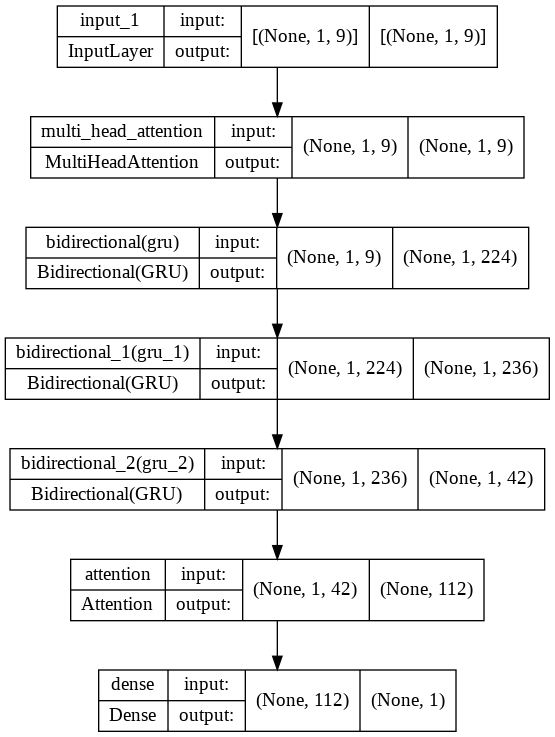

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(best_models, to_file='model_Stack_LSTM_tuner_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

<IPython.core.display.Javascript object>

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
new_model = tuner.hypermodel.build(best_hyperparameters)

history_all = []
for o in range (0,779):
  print('index:', o)
  history = new_model.fit(data_gent[o], epochs=1, validation_data=data_val_gent[o])
  history_all.append(history)



index: 0
1/1 [==============================] - 14s 14s/step - loss: 251.4072 - mean_absolute_percentage_error: 99.9967 - root_mean_squared_error: 274.3684 - val_loss: 238.7503 - val_mean_absolute_percentage_error: 99.5150 - val_root_mean_squared_error: 249.0766
index: 1
1/1 [==============================] - 0s 92ms/step - loss: 246.5212 - mean_absolute_percentage_error: 99.6974 - root_mean_squared_error: 267.2156 - val_loss: 237.9908 - val_mean_absolute_percentage_error: 97.0019 - val_root_mean_squared_error: 249.0139
index: 2
1/1 [==============================] - 0s 98ms/step - loss: 229.8819 - mean_absolute_percentage_error: 98.2541 - root_mean_squared_error: 249.0059 - val_loss: 217.9012 - val_mean_absolute_percentage_error: 94.6924 - val_root_mean_squared_error: 228.6035
index: 3
1/1 [==============================] - 0s 95ms/step - loss: 223.1983 - mean_absolute_percentage_error: 95.5055 - root_mean_squared_error: 243.1082 - val_loss: 219.9753 - val_mean_absolute_percentage_err

In [ ]:
# def plot_loss(history, title):
#     plt.figure(figsize=(10,6))
#     plt.plot(history.history['loss'], label='Train')
#     plt.plot(history.history['val_loss'], label='Validation')
#     plt.title(title)
#     plt.xlabel('Nb Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()
    
#     loss = history.history['loss']
#     min_idx = np.argmin(loss)
#     min_loss = loss[min_idx]
#     print('Minimum loss of {} reached at epoch {}'.format(min_loss, min_idx))
    
#     val_loss = history.history['val_loss']
#     min_idx = np.argmin(val_loss)
#     min_val_loss = val_loss[min_idx]
#     print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

# def plot_metrics(history, title):
#     plt.figure(figsize=(10,6))
#     plt.plot(history.history['mean_absolute_percentage_error'], label='Train', color= 'g')
#     plt.plot(history.history['val_mean_absolute_percentage_error'], label='Validation', color= 'r')
#     plt.title(title)
#     plt.xlabel('Nb Epochs')
#     plt.ylabel('MAE')
#     plt.legend()
#     plt.show()
    
#     mae = history.history['mean_absolute_percentage_error']
#     min_idx = np.argmin(mae)
#     min_mae = mae[min_idx]
#     print('Minimum performance of {} reached at epoch {}'.format(min_mae, min_idx))

#     val_mae = history.history['mean_absolute_percentage_error']
#     min_idx = np.argmin(val_mae)
#     min_val_mae = val_mae[min_idx]
#     print('Minimum validation performance of {} reached at epoch {}'.format(min_val_mae, min_idx))

# def plot_metrics_rmse(history, title):
#     plt.figure(figsize=(10,6))
#     plt.plot(history.history['root_mean_squared_error'], label='Train', color= 'g')
#     plt.plot(history.history['val_root_mean_squared_error'], label='Validation', color= 'r')
#     plt.title(title)
#     plt.xlabel('Nb Epochs')
#     plt.ylabel('MAE')
#     plt.legend()
#     plt.show()
    
#     mae = history.history['root_mean_squared_error']
#     min_idx = np.argmin(mae)
#     min_mae = mae[min_idx]
#     print('Minimum performance of {} reached at epoch {}'.format(min_mae, min_idx))

#     val_mae = history.history['val_root_mean_squared_error']
#     min_idx = np.argmin(val_mae)
#     min_val_mae = val_mae[min_idx]
#     print('Minimum validation performance of {} reached at epoch {}'.format(min_val_mae, min_idx))

In [ ]:
def plot_loss(history, title):
    history_loss = []
    history_val_loss = []
    for m in range (0,779):
      h_loss = history[m].history['loss']
      history_loss.append(h_loss)
      h_val_loss = history[m].history['val_loss']
      history_val_loss.append(h_val_loss)

    
    history_loss_array = np.array(history_loss)
    history_loss_all = history_loss_array.flatten()
    history_val_loss_array = np.array(history_val_loss)
    history_val_loss_all= history_val_loss_array.flatten()

    plt.figure(figsize=(10,6))
    plt.plot(history_loss_all, label='Train')
    plt.plot(history_val_loss_all, label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    loss = history_loss_all
    min_idx = np.argmin(loss)
    min_loss = loss[min_idx]
    print('Minimum loss of {} reached at epoch {}'.format(min_loss, min_idx))
    
    val_loss = history_val_loss_all
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

    val_loss = history_val_loss_all
    mean_idx = np.mean(val_loss)
    # mean_val_loss = val_loss[mean_idx]
    print('Average validation loss: ',mean_idx)

def plot_metrics_mape(history, title):

    history_metrics = []
    history_val_metrics = []
    for m in range (0,779):
      h_metrics = history[m].history['mean_absolute_percentage_error']
      # h_metrics = history[m].history['root_mean_squared_error']
      history_metrics.append(h_metrics)
      h_val_metrics = history[m].history['val_mean_absolute_percentage_error']
      # h_val_metrics = history[m].history['val_root_mean_squared_error']
      history_val_metrics.append(h_val_metrics)

    
    history_metrics_array = np.array(history_metrics)
    history_metrics_all = history_metrics_array.flatten()
    history_val_metrics_array = np.array(history_val_metrics)
    history_val_metrics_all= history_val_metrics_array.flatten()

    plt.figure(figsize=(10,6))
    plt.plot(history_metrics_all, label='Train')
    plt.plot(history_val_metrics_all, label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    metrics = history_metrics_all
    min_idx = np.argmin(metrics)
    min_metrics = metrics[min_idx]
    print('Minimum MAPE of {} reached at epoch {}'.format(min_metrics, min_idx))
    
    val_metrics = history_val_metrics_all
    min_idx = np.argmin(val_metrics)
    min_val_metrics = val_metrics[min_idx]
    print('Minimum validation MAPE of {} reached at epoch {}'.format(min_val_metrics, min_idx))

    val_metrics = history_val_metrics_all
    mean_idx = np.mean(val_metrics)
    # mean_val_metrics = val_metrics[min_idx]
    print('Average validation MAPE: ',mean_idx)

def plot_metrics_rmse(history, title):

    history_metrics = []
    history_val_metrics = []
    for m in range (0,779):
      # h_metrics = history[m].history['mean_absolute_error']
      h_metrics = history[m].history['root_mean_squared_error']
      history_metrics.append(h_metrics)
      # h_val_metrics = history[m].history['val_mean_absolute_error']
      h_val_metrics = history[m].history['val_root_mean_squared_error']
      history_val_metrics.append(h_val_metrics)

    
    history_metrics_array = np.array(history_metrics)
    history_metrics_all = history_metrics_array.flatten()
    history_val_metrics_array = np.array(history_val_metrics)
    history_val_metrics_all= history_val_metrics_array.flatten()

    plt.figure(figsize=(10,6))
    plt.plot(history_metrics_all, label='Train')
    plt.plot(history_val_metrics_all, label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    metrics = history_metrics_all
    min_idx = np.argmin(metrics)
    min_metrics = metrics[min_idx]
    print('Minimum RMSE of {} reached at epoch {}'.format(min_metrics, min_idx))
    
    val_metrics = history_val_metrics_all
    min_idx = np.argmin(val_metrics)
    min_val_metrics = val_metrics[min_idx]
    print('Minimum validation RMSE of {} reached at epoch {}'.format(min_val_metrics, min_idx))

    val_metrics = history_val_metrics_all
    mean_idx = np.mean(val_metrics)
    # mean_val_metrics = val_metrics[mean_idx]
    print('Average validation RMSE: ', mean_idx)

# van_lstm_hist[0].history['loss']


# # plt.plot(hist[0].history)
# hist_l = np.array(hist_loss)
# his_l_ = hist_l.flatten()
# hist_val_loss = np.array(hist_val_loss)
# hist_v = hist_val_loss.flatten()
# # plt.plot(hist)
# plt.plot(his_l_, label = 'train')
# plt.plot(hist_v, label = 'val')

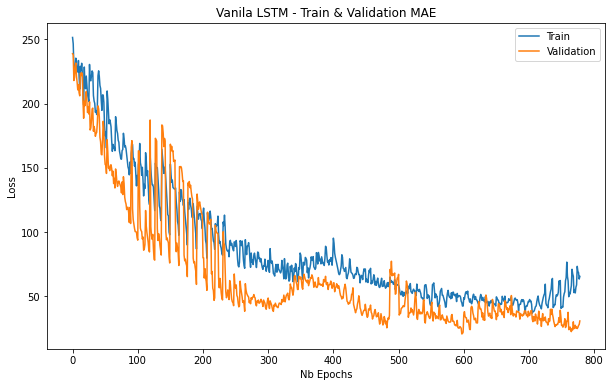

Minimum loss of 36.90910720825195 reached at epoch 694
Minimum validation loss of 20.764049530029297 reached at epoch 597
Average validation loss:  69.08188155128958


In [ ]:
plot_loss(history_all, 'Vanila LSTM - Train & Validation MAE')

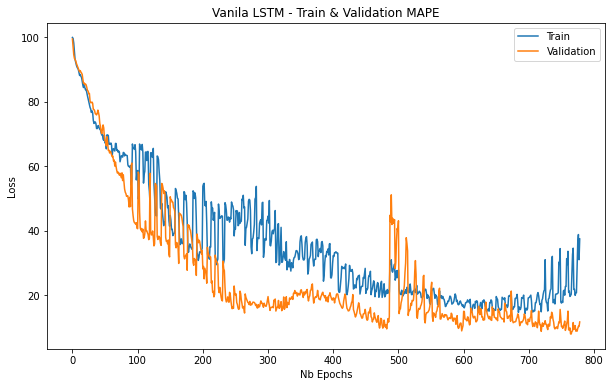

Minimum MAPE of 14.270569801330566 reached at epoch 694
Minimum validation MAPE of 8.025480270385742 reached at epoch 764
Average validation MAPE:  26.52964117713703


In [ ]:
plot_metrics_mape(history_all, 'Vanila LSTM - Train & Validation MAPE')

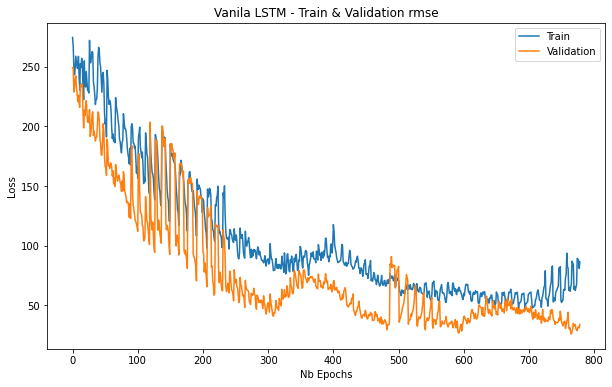

Minimum RMSE of 46.25113296508789 reached at epoch 694
Minimum validation RMSE of 26.162748336791992 reached at epoch 765
Average validation RMSE:  79.42559317905881


In [ ]:
plot_metrics_rmse(history_all, 'Vanila LSTM - Train & Validation rmse')

In [ ]:
val_mae_per_epoch = history.history['val_loss']
best_epoch = val_mae_per_epoch.index(min(val_mae_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [ ]:
evaluation = []
for m in range (0,779):
  evaluated_LSTM = new_model.evaluate(data_test_gent[m])
  evaluation.append(evaluated_LSTM)

1/1 [==============================] - 0s 47ms/step - loss: 78.1057 - mean_absolute_percentage_error: 25.2488 - root_mean_squared_error: 87.2404


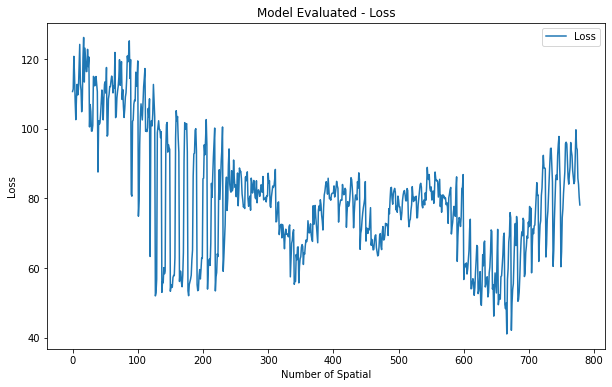

minimum Loss:  41.08745574951172
minimum Loss at epoch:  666
average:  80.50774601457667


In [ ]:

# evaluation.shape

evaluation_array = np.array(evaluation)
# evaluation_flatten= evaluation_array.flatten()
evaluation_array.shape
eva = np.hsplit(evaluation_array,3)
eva[0]

plt.figure(figsize=(10,6))
plt.plot(eva[0], label='Loss')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Loss')
plt.xlabel('Number of Spatial')
plt.ylabel('Loss')
plt.legend()
plt.show()
print('minimum Loss: ', np.min(eva[0]))
print('minimum Loss at epoch: ',np.argmin(eva[0]))
print('average: ', np.mean(eva[0]))

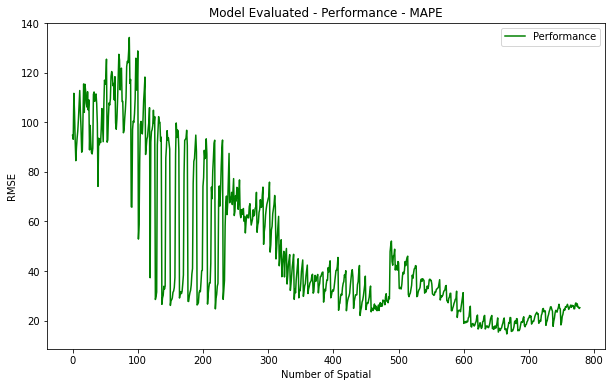

minimum MAPE:  14.642751693725586
minimum MAPE at epoch:  666
average:  48.902746276463716


In [41]:
plt.figure(figsize=(10,6))
plt.plot(eva[1], label='Performance', color='green')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Performance - MAPE')
plt.xlabel('Number of Spatial')
plt.ylabel('RMSE')
plt.legend()
plt.show()
print('minimum MAPE: ', np.min(eva[1]))
print('minimum MAPE at epoch: ',np.argmin(eva[1]))
print('average: ', np.mean(eva[1]))

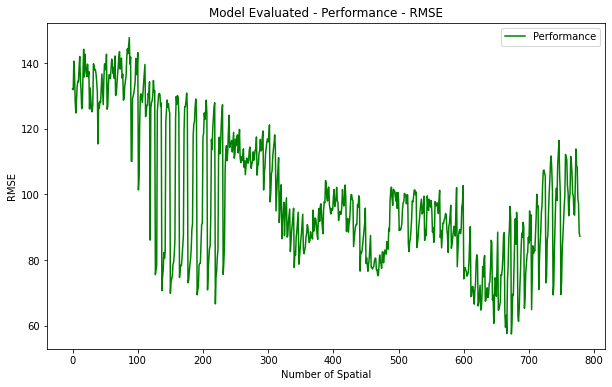

minimum RMSE:  57.49253463745117
minimum RMSE at epoch:  673
average:  99.91766343710512


In [40]:
plt.figure(figsize=(10,6))
plt.plot(eva[2], label='Performance', color='green')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Performance - RMSE')
plt.xlabel('Number of Spatial')
plt.ylabel('RMSE')
plt.legend()
plt.show()
print('minimum RMSE: ', np.min(eva[2]))
print('minimum RMSE at epoch: ',np.argmin(eva[2]))
print('average: ', np.mean(eva[2]))

In [ ]:
# lstm_at_history = []
# for l in range(0,779):
#   print('index: ',l)
#   at_history = model_attention.fit(data_gent[l], validation_data=data_val_gent[k], epochs=epochs, verbose=1) 
#   lstm_at_history.append(at_history)

# # model_attention.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)